<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Analysis-of-full-length-PacBio-sequencing-of-influenza-mRNAs" data-toc-modified-id="Analysis-of-full-length-PacBio-sequencing-of-influenza-mRNAs-1">Analysis of full-length PacBio sequencing of influenza mRNAs</a></span><ul class="toc-item"><li><span><a href="#Set-up-for-analysis" data-toc-modified-id="Set-up-for-analysis-1.1">Set up for analysis</a></span><ul class="toc-item"><li><span><a href="#Import-Python-modules" data-toc-modified-id="Import-Python-modules-1.1.1">Import Python modules</a></span></li><li><span><a href="#Define-/-create-directories" data-toc-modified-id="Define-/-create-directories-1.1.2">Define / create directories</a></span></li><li><span><a href="#How-many-CPUs-to-use" data-toc-modified-id="How-many-CPUs-to-use-1.1.3">How many CPUs to use</a></span></li></ul></li><li><span><a href="#Build-CCSs" data-toc-modified-id="Build-CCSs-1.2">Build CCSs</a></span><ul class="toc-item"><li><span><a href="#Get-subreads-files" data-toc-modified-id="Get-subreads-files-1.2.1">Get subreads files</a></span></li><li><span><a href="#Run-ccs-and-read-results" data-toc-modified-id="Run-ccs-and-read-results-1.2.2">Run <code>ccs</code> and read results</a></span></li></ul></li><li><span><a href="#Process-CCS's" data-toc-modified-id="Process-CCS's-1.3">Process CCS's</a></span><ul class="toc-item"><li><span><a href="#Barcoded-CCS-features" data-toc-modified-id="Barcoded-CCS-features-1.3.1">Barcoded CCS features</a></span></li><li><span><a href="#Flu-alignment-targets" data-toc-modified-id="Flu-alignment-targets-1.3.2">Flu alignment targets</a></span></li><li><span><a href="#Match-and-align-CCSs" data-toc-modified-id="Match-and-align-CCSs-1.3.3">Match and align CCSs</a></span></li><li><span><a href="#Stats-on-matching-/-alignment" data-toc-modified-id="Stats-on-matching-/-alignment-1.3.4">Stats on matching / alignment</a></span></li><li><span><a href="#Get-CCSs-with-gene-aligned" data-toc-modified-id="Get-CCSs-with-gene-aligned-1.3.5">Get CCSs with gene aligned</a></span></li></ul></li><li><span><a href="#Quality-control-alignments" data-toc-modified-id="Quality-control-alignments-1.4">Quality-control alignments</a></span><ul class="toc-item"><li><span><a href="#Barcode-accuracy" data-toc-modified-id="Barcode-accuracy-1.4.1">Barcode accuracy</a></span></li><li><span><a href="#Additional-alignments" data-toc-modified-id="Additional-alignments-1.4.2">Additional alignments</a></span></li><li><span><a href="#Excessive-alignment-trimming" data-toc-modified-id="Excessive-alignment-trimming-1.4.3">Excessive alignment trimming</a></span><ul class="toc-item"><li><span><a href="#Trimming-of-query-start" data-toc-modified-id="Trimming-of-query-start-1.4.3.1">Trimming of query start</a></span></li><li><span><a href="#Trimming-of-target-start" data-toc-modified-id="Trimming-of-target-start-1.4.3.2">Trimming of target start</a></span></li><li><span><a href="#Trimming-query-ends" data-toc-modified-id="Trimming-query-ends-1.4.3.3">Trimming query ends</a></span></li><li><span><a href="#Trimming-target-ends" data-toc-modified-id="Trimming-target-ends-1.4.3.4">Trimming target ends</a></span></li></ul></li><li><span><a href="#Get-QC-ed-alignments" data-toc-modified-id="Get-QC-ed-alignments-1.4.4">Get QC-ed alignments</a></span></li></ul></li><li><span><a href="#Lengths-of-aligned-genes" data-toc-modified-id="Lengths-of-aligned-genes-1.5">Lengths of aligned genes</a></span></li></ul></li></ul></div>

# Analysis of full-length PacBio sequencing of influenza mRNAs
The material from the 10X libraries for the *IFN_enriched* sample was enriched for viral mRNAs by semi-specific PCR, and then sequenced by PacBio.
Here we analyze those data.

## Set up for analysis
First, we do some things to set up this Jupyter notebook.

### Import Python modules
We import the Python modules used.

We make extensive use of [dms_tools2](https://jbloomlab.github.io/dms_tools2/) to handle the PacBio data.

We import [plotnine](https://plotnine.readthedocs.io/en/latest/) for plotting using a ggplot2-like syntax.

In [1]:
import os
import glob
import subprocess
import shutil
import multiprocessing
import warnings
import collections
warnings.simplefilter('ignore')

import pandas
from IPython.display import display, HTML
import Bio.SeqIO

import dms_tools2
print("Using dms_tools2 version {0}".format(dms_tools2.__version__))
from dms_tools2.ipython_utils import showPDF
from dms_tools2.plot import COLOR_BLIND_PALETTE_GRAY

# import plotnine for plotting
from plotnine import *
_ = theme_set(theme_bw(base_size=12))

Using dms_tools2 version 2.3.dev0


### Define / create directories
We define the names of key directories for input and output, and create these directories if needed:

In [2]:
# top results directory
resultsdir = './results/'

# directory for PacBio results
pacbioresultsdir = os.path.join(resultsdir, 'pacbio')
os.makedirs(pacbioresultsdir, exist_ok=True)

### How many CPUs to use
Specify max number to use:

In [3]:
max_cpus = 14 # max number of CPUs to use
ncpus = max(multiprocessing.cpu_count(), max_cpus)

## Build CCSs 
We build the circular consensus sequences (CCSs) using the PacBio software.

### Get subreads files 
We have multiple sequencing runs:
  - A run from June-8-2017 done at the UW PacBio core. This run used a PacBio RSII machine.
  - A run from December-7-2017 done at the Fred Hutch Genomics core. This run used a PacBio Sequel machine.
  
Note that the material sequenced for these two runs was **not** identical. 
The balance of genes that were mixed differed, as well as the size selection and the way that the libraries were loaded.
Therefore, we do not expect the same balance of different reads in the two runs.

In addition, the data were processed differently.
For the Hutch Genomics Core runs, the data are already processed into a `*.subreads.bam` file, while for UW PacBio core runs it is still in the `*.bas.h5` file.

In [4]:
seqruns = ['2017-06-08', '2017-12-07']

seqdirs = {
        '2017-06-08':'/fh/fast/bloom_j/SR/ngs/pacbio_UW/170608 Pacbio single cell/Emulsion Reaction/ABR_C_MACS.AR_0kb',
        '2017-12-07':'/fh/fast/bloom_j/SR/ngs/pacbio/171207_bloom_j/r54228_20171201_171054/1_A01',
        }

bam_already = {'2017-06-08':False, '2017-12-07':True}

Now we get the `*.subreads.bam` file for each run.
If they already exist (e.g., if data were returned by the Fred Hutch Genomics Core), we just need to get the name of the file.
But if they don't exist (e.g., if data were returned from UW PacBio Core), we need to run the PacBio [bax2bam](https://github.com/PacificBiosciences/bax2bam) software to create the `*subreads.bam` files from the `*.bas.h5` files.

In [5]:
# put or copy subreads into this directory
subreadsdir = os.path.join(pacbioresultsdir, 'subreads')
os.makedirs(subreadsdir, exist_ok=True)

# store name of subreads files for each sequencing run
subreads = dict([(seqrun, os.path.join(subreadsdir, seqrun + '.subreads.bam'))
                 for seqrun in seqruns])

# get subreads files
for (seqrun, subreadsfile) in subreads.items():
    print("\nGetting subreads for {0} sequencing run".format(seqrun))
    
    if os.path.isfile(subreadsfile):
        print("Subreads file already exists: {0}".format(subreadsfile))
    
    elif bam_already[seqrun]:
        print("Looking for existing subreads file...")
        filepattern = os.path.join(seqdirs[seqrun], '*.subreads.bam')
        existingfiles = glob.glob(filepattern)
        assert existingfiles, "No file matching expected pattern of {0}".format(filepattern)
        assert len(existingfiles) == 1, "Expected one file, but found multiple:\n{0}".format(
                '\n'.join(existingfiles))
        print("Copying subreads file {0} to {1}...".format(existingfiles[0], subreadsfile))
        shutil.copy(existingfiles[0], subreadsfile)
        shutil.copy(existingfiles[0] + '.pbi', subreadsfile + '.pbi')
        print("Completed copying file.")
    
    else:
        print("Building subreads using `bax2bam` version {0}".format(
                subprocess.check_output(['bax2bam', '--version']).decode('utf-8').strip()))
        baxfiles = []
        for (dpath, dirnames, fnames) in os.walk(seqdirs[seqrun]):
            baxfiles += [os.path.join(dpath, fname) for fname in fnames if fname.endswith('.bax.h5')] 
        assert len(baxfiles) > 0, "found no `*.bax.h5` files"
        print("Will build subreads from the following `*.bax.h5` files:\n\t{0}".format(
                '\n\t'.join(baxfiles)))
        print("Now running `bax2bam`...")
        ! bax2bam \
                {' '.join(['"' + x + '"' for x in baxfiles])} \
                -o {subreadsfile.replace('.subreads.bam', '')} \
                --subread
        print("Completed running `bax2bam` to create {0}".format(subreadsfile))
        assert os.path.isfile(subreadsfile)


Getting subreads for 2017-06-08 sequencing run
Subreads file already exists: ./results/pacbio/subreads/2017-06-08.subreads.bam

Getting subreads for 2017-12-07 sequencing run
Subreads file already exists: ./results/pacbio/subreads/2017-12-07.subreads.bam


### Run `ccs` and read results
We build CCS's using PacBio's algorithm as implemented in the [ccs program](https://github.com/PacificBiosciences/unanimity/blob/develop/doc/PBCCS.md).

We only want reasonably high-quality CCSs.
The [ccs program](https://github.com/PacificBiosciences/unanimity/blob/master/doc/PBCCS.md) provides two ways to control the "accuracy" of reads.
The first is the `--minPasses` option, which corresponds to how many subreads we require to call a circular consensus sequence.
The second is the `--minPredictedAccuracy` option, which provides an explicit estimate of the accuracy.
We will further post-process the CCSs, so we set reasonably high but not extremely stringent values: 3 passes, and at least 99.9% accuracy.

We then read the results of each sequencing run into ` dms_tools2.pacbio.CCS` object and summarize the results on the number of high-quality CCSs generated:


Running `ccs` for sequencing run 2017-06-08
The `ccs` output already exists, so using that existing output.

Running `ccs` for sequencing run 2017-12-07
The `ccs` output already exists, so using that existing output.

Here are statistics on the `ccs` results:


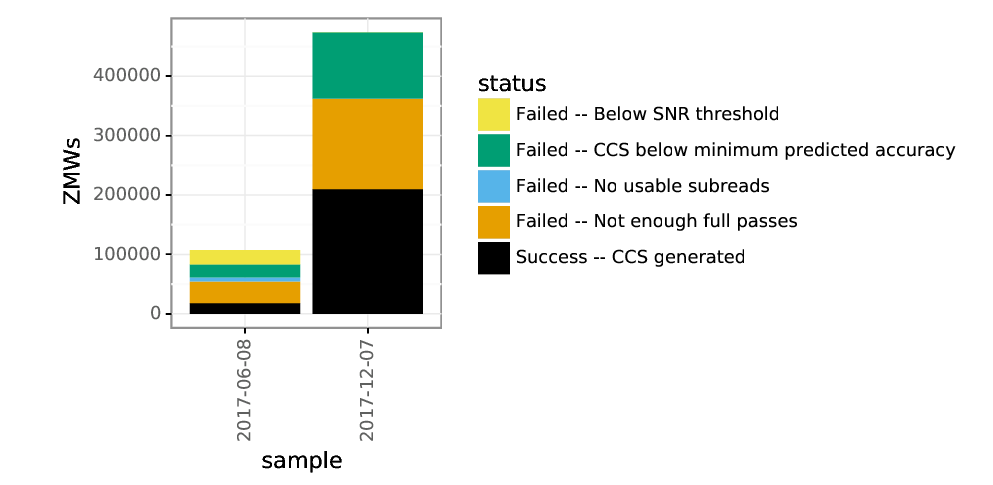

sample,status,number,fraction
2017-12-07,Success -- CCS generated,209930,0.4428
2017-12-07,Failed -- Not enough full passes,152429,0.3215
2017-12-07,Failed -- CCS below minimum predicted accuracy,110974,0.2341
2017-06-08,Failed -- Not enough full passes,36289,0.3371
2017-06-08,Failed -- Below SNR threshold,24052,0.2235
2017-06-08,Failed -- CCS below minimum predicted accuracy,22063,0.2050
2017-06-08,Success -- CCS generated,18063,0.1678
2017-06-08,Failed -- No usable subreads,6810,0.0633


In [6]:
ccsdir = os.path.join(pacbioresultsdir, 'ccs')
os.makedirs(ccsdir, exist_ok=True)

ccslist = []
for (seqrun, subreadsfile) in subreads.items():
    print("\nRunning `ccs` for sequencing run {0}".format(seqrun))
        
    reportfile = os.path.join(ccsdir, seqrun + '_report.csv')
    bamfile = os.path.join(ccsdir, seqrun + '_ccs.bam')
    logfile = os.path.join(ccsdir, seqrun + '_log.txt')
        
    if all(map(os.path.isfile, [reportfile, bamfile])):
        print("The `ccs` output already exists, so using that existing output.")
    else:  
        print("Running {0}...".format(
                subprocess.check_output(['ccs', '--version']).decode(
                'utf-8').strip()))
        ! ccs \
            --minLength 100 \
            --maxLength 5000 \
            --minPasses 3 \
            --minPredictedAccuracy 0.999 \
            --logFile {logfile} \
            --reportFile {reportfile} \
            --polish \
            --numThreads {ncpus} \
            {subreadsfile} \
            {bamfile}
        print("Completed `ccs` run.")
        
    ccslist.append(dms_tools2.pacbio.CCS(seqrun, bamfile, reportfile))

print("\nHere are statistics on the `ccs` results:")
zmw_plot = os.path.join(ccsdir, 'ZMW_plot.pdf')
showPDF(zmw_plot)

ccs_report = dms_tools2.pacbio.summarizeCCSreports(
                ccslist, 'zmw', zmw_plot)
display(HTML(ccs_report.query('fraction > 0.005').to_html(index=False)))

## Process CCS's
The PacBio sequencing was performed on PCR-amplified product.
This PCR product was amplified off the 10X barcoded material using semi-specific PCR with one end specifically annealing to flu transcripts.
We want to identify the CCS's that represent properly barcoded 10X material from influenza genes, and then call the barcodes and align the barcoded mRNA to influenza transcripts.

### Barcoded CCS features
This [10X technical note](https://teichlab.github.io/scg_lib_structs/data/CG000108_AssayConfiguration_SC3v2.pdf) outlines the sequences appended by the v2 10X single-cell 3' kit used in these experiments. 
Specifically:
![./data/images/10Xschematic.png](./data/images/10Xschematic.png)

Zooming in on the 3' adaptor sequence, it is:
`CTACACGACGCTCTTCCGATCT-NNNNNNNNNNNNNNNN-NNNNNNNNNN-TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTVN` where the dash-delimited sequences are the read-1 priming site, the 16XN cell barcode, the 10XN UMI, the 30XT oligo-dT primer, followed by `V` (anything but `T`) and `N` (nominally, first nucleotide of upstream of mRNA polyA tail).

For the PCR to enrich the 10X product, Alistair used a 3' primer that anneals to this adaptor, namely:

In [7]:
primer3 = 'CTACACGACGCTCTTCCGATCT'
print("The length of the 3' primer is {0} nt".format(len(primer3)))

The length of the 3' primer is 22 nt


For the 5' primer, Alistair used a mix of primers that covered each of the 8 flu gene segments:

In [8]:
primer5_mix = {'PB2':'GCGAAAGCAGGTCAATTATATTCAATATGGAAAG',
               'PB1':'GCGAAAGCAGGCAAACCATTTG',
               'PA':'GCGAAAGCAGGTACTGATTCAAAATGG',
               'HA':'GCAAAAGCAGGGGAAAATAAAAACAACC',
               'NP':'GCAAAAGCAGGGTAGATAATCACTCAC',
               'NA':'GCGAAAGCAGGAGTTTAAATGAATCCAAAC',
               'M':'GCAAAAGCAGGTAGATATTGAAAGATGAGTC',
               'NS':'GCAAAAGCAGGGTGACAAAGACATAATG',
              }
print("The length of the 5' primer ranges from {0} to {1} nt".format(
        min(map(len, primer5_mix.values())), max(map(len, primer5_mix.values()))))

The length of the 5' primer ranges from 22 to 34 nt


### Flu alignment targets
We want to align the barcoded sequences to the flu mRNAs.
We will just align to the wildtype flu sequences, and then call the synonymous barcodes later.
The flu mRNA sequences are in [./data/flu_sequences/flu-wsn-mRNA.fasta](./data/flu_sequences/flu-wsn-mRNA.fasta).
We want to align to the sequence **interior** to the primer binding sites defined above: the region between the custom 5' primer and the polyA tail.
We therefore read in the mRNAs, and then trim each from the 5' termini to the end of the primer binding site, and then write these to a file to use as the alignment targets:

In [9]:
targets = []
for full_mRNA in Bio.SeqIO.parse('./data/flu_sequences/flu-wsn-mRNA.fasta', 'fasta'):
    full_mRNA_seq = str(full_mRNA.seq)
    primer = [p for p in primer5_mix.values() if full_mRNA_seq.count(p)]
    assert len(primer) == 1, "matched multiple primers in {0}".format(full_mRNA.name)
    targetseq = full_mRNA_seq[full_mRNA_seq.index(primer[0]) + len(primer[0]) : ]
    print("Aligning to a {0} nt region of {1}".format(len(targetseq), full_mRNA.name))
    targets.append((full_mRNA.name, targetseq))

aligndir = os.path.join(pacbioresultsdir, 'alignments')
os.makedirs(aligndir, exist_ok=True)
targetfile = os.path.join(aligndir, 'targets.fasta')
with open(targetfile, 'w') as f:
    f.write('\n'.join('>{0}\n{1}'.format(*tup) for tup in targets))

Aligning to a 2285 nt region of fluPB2
Aligning to a 2297 nt region of fluPB1
Aligning to a 2183 nt region of fluPA
Aligning to a 1725 nt region of fluHA
Aligning to a 1516 nt region of fluNP
Aligning to a 1357 nt region of fluNA
Aligning to a 973 nt region of fluM1
Aligning to a 285 nt region of fluM2
Aligning to a 839 nt region of fluNS1
Aligning to a 367 nt region of fluNS2


### Match and align CCSs
We use the function `dms_tools2.pacbio.matchAndAlignCCS` to go through the CCS's, find the ones that are "barcoded" (have the proper elements), and the align these barcoded genes.
All the results go into a pandas data frame.

Specifically, we look for CCS's that have:
  - Any 5' primer from Alistair's mix, trimmed a bit at the start since the first few nucleotides in the CCS might be off. We call this *termini5*.
  - The mRNA itself, which we call the *gene*. Since we define the polyA tail as beginning on the first `A` at the polyA signal, the gene must end on a non-`A` nucleotide (which is the IUPAC code `B`).
  - The polyA tail, which is effectively a spacer between the *gene* and the *UMI* / *barcode*. This tail is expected to be 30 `A`'s from 10X primer, but we allow it to be anything greater than 25 to account for the sloppiness in sequencing and primer synthesis associated with runs. We also use [regex fuzzy matching](https://stackoverflow.com/a/15975649) to allow the polyA to have up to two non-`A` nucleotides internal to it, since for instance the `VN` tooth in the oligo-dT primer might sometimes anneal in the wrong spot. We call this the *spacer* in the call to `dms_tools2.pacbio.matchAndAlignCCS`, but then rename to *polyA*.
  - The 10-nucleotide UMI from the 10X primer, which we call *UMI*.
  - The 16-nucleotide cell barcode from the 10X primer, which we call *barcode*.
  - The 3' primer that Alistair used, which anneals in the read 1 primer binding site on the 10X primer. We call this *termini3*.
  
Note also that in the call to `dms_tools2.pacbio.matchAndAlignCCS`, we specify that *M1* and *M2* are isoforms, and *NS1* and *NS2* are isoforms.
  
We don't require a match to the first 5 nt of each termini, as sometimes the ends of the CCS's can be "sloppy":

In [10]:
mapper = dms_tools2.minimap2.Mapper(targetfile,
        dms_tools2.minimap2.OPTIONS_VIRUS_W_DEL,
        target_isoforms={'fluM1':['fluM2'], 'fluM2':['fluM1'],
                         'fluNS1':['fluNS2'], 'fluNS2':['fluNS1']})
print("Performing alignments with minimap2 version {0}".format(mapper.version))

trim_ends = 5 # trim this many off each termini

df_all = dms_tools2.pacbio.matchAndAlignCCS(
        ccslist=ccslist,
        mapper=mapper,
        termini5='|'.join([s[trim_ends : ] for s in primer5_mix.values()]),
        gene='N+B',
        spacer='AAA(A{19,}){e<=2}AAA', # regex fuzzy matching allows 2 mismatch
        umi='N{10}',
        barcode='N{16}',
        termini3=dms_tools2.utils.reverseComplement(primer3)[ : trim_ends],
        ).rename(columns={'has_spacer':'has_polyA'})

print("Attempted to match and align all {0} CCSs".format(len(df_all)))

Performing alignments with minimap2 version 2.10-r761
Attempted to match and align all 227993 CCSs


### Stats on matching / alignment
Below we analyze the statistics on the matching and aligning of the CCSs:

Here is a table of the matching / alignment statistics:


samplename,category,number of CCSs,percent
2017-06-08,total,18063,100
2017-06-08,has termini3,18057,99
2017-06-08,has polyA,16731,92
2017-06-08,has termini5,4248,23
2017-06-08,barcoded,3634,20
2017-06-08,gene aligned,3633,20
2017-06-08,CCS aligned,4455,24
2017-12-07,total,209930,100
2017-12-07,has termini3,209788,99
2017-12-07,has polyA,190750,90



Here is a plot of the results:


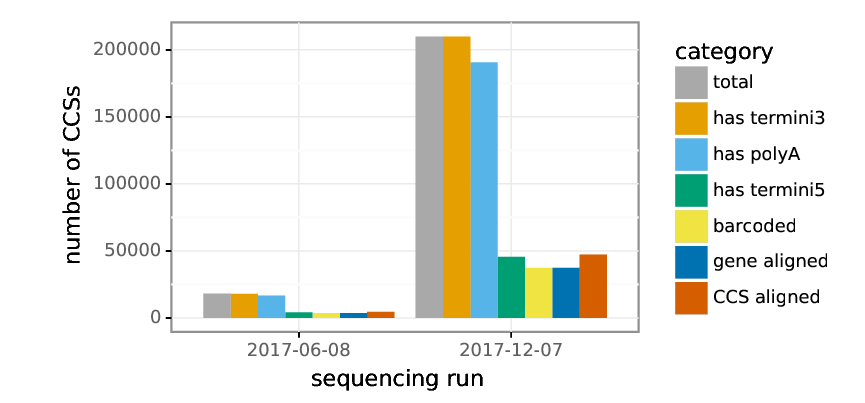

In [11]:
# possible matching / alignment categories
match_align_cats = ['total', 'has_termini3', 'has_polyA', 'has_termini5',
                    'barcoded', 'gene_aligned', 'CCS_aligned']

# tabulate statistics on matching / alignment
match_align_df = (
    df_all
    .assign(total=True)
    .melt(id_vars=['samplename'], 
          value_vars=match_align_cats,
          var_name='category',
          value_name='number of CCSs')
    .groupby(['samplename', 'category'], as_index=False)
    .aggregate('sum')
    .assign(category=lambda x: pandas.Categorical(
            x.category.str.replace('_', ' '), 
            [col.replace('_', ' ') for col in match_align_cats]))
    .sort_values(['samplename', 'category'])
    .assign(percent=lambda x: 100 * x['number of CCSs'] / 
               x.groupby('samplename')['number of CCSs'].transform('max'))
    )
print("Here is a table of the matching / alignment statistics:")
display(HTML(match_align_df.to_html(index=False, float_format='%d')))

# plot the matching alignment statistics
match_align_plot = os.path.join(aligndir, 'match_align_plot.pdf')
(ggplot(match_align_df, aes('samplename', 'number of CCSs')) +
    geom_bar(aes(fill='category'), position='dodge', stat='identity') +
    scale_fill_manual(COLOR_BLIND_PALETTE_GRAY) +
    xlab('sequencing run') 
    ).save(match_align_plot,
           width=1.5 * (1 + len(seqruns)),
           height=3)
print("\nHere is a plot of the results:")
showPDF(match_align_plot, width=700)

We see that across both samples, the vast majority of CCSs have the 3' termini and the polyA, as might be expected given that those need to be there for the 3' primer to work.

However, only a bit over 20% have the 5' termini.
This could be because only a small fraction of all sequences in the initial PCR template pool will be flu mRNAs with the right termini for the 5' primer, so there may be spurious amplification (by the 3' primer or just linear amplification product) that doesn't have the 5' termini.

Most of the CCSs that have the 5' termini are also *barcoded* in the sense that they fully match the expected patterns that allow us to call a barcode and UMI.

Of these *barcoded* CCSs, most of them have mRNA inserts ("genes") that align to the flu targets, and so are in the *gene aligned* category.

We also see that if we align the full CCS without requiring it to match the termini / barcode / polyA, we get a few more than for the *gene aligned* category, indicating that some of the CCSs for which we can't call barcodes still have flu in them.
These may have mutations in the termini / polyA, or they may be some sort of chimera.
In any case, since the *CCS aligned* category is only modestly larger than the *gene aligned* category, for all subsequent analyses we'll focus just on the *gene aligned* CCSs.

### Get CCSs with gene aligned
For the reasons explained immediately above, all remaining analyses will focus only on the CCSs in the *gene aligned* category.
Get these in a data frame:

In [12]:
df_aligned = df_all.query('gene_aligned').reset_index(drop=True)

## Quality-control alignments
For the CCSs for which the gene insert aligned to flu, we now do some quality controlling on several important aspects.

We do this by adding a column to our data frame named `QC_filtered`.
Initially all entries in this columns are the string "passes_filters".
As we go through each filter in order below, we add a string describing the filtering reason for each CCS that fails that filter.
Once a CCS fails one filter (in the order they are provided below), we don't continue checking it against the other filters.

In [146]:
df_aligned['pass_QC'] = True
df_aligned['QC_fail_reason'] = 'passes_QC'

### Barcode accuracy
We want the barcodes called in the CCSs to be high accuracy. 
This might not be the case if molecules with different barcodes anneal during the PCR, such that a different barcode is sequenced on each strand of the SMRTbell that forms the CCS.
So we tabulate some statistics about the distribution of barcode accuracies among CCSs that pass our filters so far:

In [147]:
(df_aligned
    .query('pass_QC')
    .groupby('samplename')
    .barcode_accuracy
    .describe(percentiles=[0.001, 0.01, 0.02])
    )

,count,mean,std,min,0.1%,1%,2%,50%,max
samplename,,,,,,,,,
2017-06-08,3633.0,0.999863,0.001430,0.968363,0.979985,0.996868,0.999685,1.0,1.0
2017-12-07,37416.0,0.999962,0.000684,0.968675,0.989011,0.999828,0.999980,1.0,1.0


Below we see that the barcode accuracies are consistently very high, with over 98% having accuracies that exceed the accuracy threshold of 0.999 used when building the CCSs with PacBio's [ccs program](https://github.com/PacificBiosciences/unanimity/blob/develop/doc/PBCCS.md), and all of them having accuracies of >96%.
Just to be safe, we will filter for CCSs that have a barcode accuracy $\ge$0.999, which will eliminate only a very small fraction.

We not in the data frame which of the CCSs that have not already been filtered fail this barcode accuracy filter:

In [148]:
fail_index = df_aligned.query('pass_QC & (barcode_accuracy < 0.999)').index
df_aligned.loc[fail_index, 'pass_QC'] = False
df_aligned.loc[fail_index, 'QC_fail_reason'] = 'low barcode accuracy'

### Additional alignments
We want to get rid of CCSs that align to multiple different influenza genes.
The reason is that these probably represent some sort of PCR chimera / fusion during the library preparation.
Note that we are only looking at multiple alignments to different targets / isoforms (we specified that M1 / M2 and NS1 / NS2 are isoforms in the `target_isoforms` argument to the `dms_tools2.minimap2.Mapper`), so this will not alignments that involve the same gene (these could be complex deletions) or different splice forms.
First, we tabulate some statistics about the distribution of the number of additional alignments to different targets among CCSs that pass our filters so far:

In [149]:
(df_aligned
    .query('pass_QC')
    .groupby('samplename')
    .gene_aligned_n_additional_difftarget
    .describe(percentiles=[0.99, 0.999, 0.9999])
    )

,count,mean,std,min,50%,99%,99.9%,99.99%,max
samplename,,,,,,,,,
2017-06-08,3580.0,0.001397,0.037351,0.0,0.0,0.0,1.0,1.0,1.0
2017-12-07,37224.0,0.001827,0.048588,0.0,0.0,0.0,1.0,2.0,2.0


There are very few CCSs with additional alignments to other targets (less than 1%), and we remove them:

In [150]:
fail_index = df_aligned.query('pass_QC & gene_aligned_n_additional_difftarget').index
df_aligned.loc[fail_index, 'pass_QC'] = False
df_aligned.loc[fail_index, 'QC_fail_reason'] = 'aligns to multiple targets'

### Excessive alignment trimming
For perfect matches the of query CCSs to the target flu mRNAs, alignment of the query to the target is end-to-end, with no trimming of either the query or the target at either end.

However, in practice, in many cases there is trimming of the query or the target.
Here we QC filter based on the presence of excessive trimming.

#### Trimming of query start
Based on the way that the products were PCR-amplified, we expect the query starts to align exactly with the target start, so there shouldn't be any need for trimming.
Below are tabulated statistics about the distribution of trimming at the query start:

In [151]:
(df_aligned
    .query('pass_QC')
    .groupby('samplename')
    .gene_aligned_n_trimmed_query_start
    .describe(percentiles=[0.99, 0.999, 0.9999])
    )

,count,mean,std,min,50%,99%,99.9%,99.99%,max
samplename,,,,,,,,,
2017-06-08,3575.0,0.276084,15.790498,0.0,0.0,0.0,3.426,611.6180,944.0
2017-12-07,37176.0,0.214601,12.043206,0.0,0.0,0.0,3.000,594.6675,1092.0


Most (>99%) queries align exactly with the target at their start, with no trimming. 
There are a few nucleotides trimmed from a modest fraction (<1%).
This modest trimming is explainable---the 5' primers are similar for the different flu genes, so there may occassionally be mis-priming so that the primer amplifies a different flu mRNA, which might lead to a bit of trimming at the very start of the alignment.
There are then a very small number (less than <0.01%) that have very large amounts trimmed.
We will discard CCSs with more than 5 nucleotides trimmed from the query start:

In [152]:
fail_index = df_aligned.query('pass_QC & (gene_aligned_n_trimmed_query_start > 5)').index
df_aligned.loc[fail_index, 'pass_QC'] = False
df_aligned.loc[fail_index, 'QC_fail_reason'] = 'excessive trimming of query start'

#### Trimming of target start
We also expect all of the alignments to start exactly at the begin of the target, because the PCR-amplification should lead to this.
Below are tabulated statistics about the distribution of trimming at the target start:

In [153]:
(df_aligned
    .query('pass_QC')
    .groupby('samplename')
    .gene_aligned_n_trimmed_target_start
    .describe(percentiles=[0.99, 0.999, 0.9999])
    )

,count,mean,std,min,50%,99%,99.9%,99.99%,max
samplename,,,,,,,,,
2017-06-08,3573.0,0.291912,16.120231,0.0,0.0,0.0,3.0,638.0196,962.0
2017-12-07,37153.0,0.134067,14.180187,0.0,0.0,0.0,3.0,60.9680,1884.0


This distribution looks very similar to that for trimming of the query starts immediately above, and (for the same logic explained there), we will discard CCSs with more than 5 nucleotides trimmed from the target start:

In [154]:
fail_index = df_aligned.query('pass_QC & (gene_aligned_n_trimmed_target_start > 5)').index
df_aligned.loc[fail_index, 'pass_QC'] = False
df_aligned.loc[fail_index, 'QC_fail_reason'] = 'excessive trimming of target start'

#### Trimming query ends
We expect the queries to end at the end of the target, and so there to be no clipping of teh query ends. 
There are three plausible reasons for clipping of the query ends:
  1. A PCR artifact that leads to fusion of a flu gene with a cellular gene. We tried to filter out fusions of two different flu genes above by removing CCSs with additional alignments to a different flu target, but that filter won't remove fusions to things that aren't flu genes--although these are expected to be much more abundant. We would like to filter CCSs for which this occurs.
  2. The transcription of the mRNA from the query continuing past the polyA tail, or the polyA tail not be fully trimmed and removed. We might want to retain these. However, we expect the extension that has tobe trimmed in this case to be small, probably less than 50 nt.
  3. There is an internal deletion and for whatever reason the mapping failed to handle it properly and just trimmed the region after the deletion. We want to keep these. We would expect them to align with "additional alignments" since the trimmed region should be in a different alignment.
  
Below we tabulate some statistics on the distribution of trimming, for CCSs both with and without additional alignments (these distributions are hard to plot since they are so skewed):

In [155]:
(df_aligned
    .query('pass_QC')
    .assign(has_additional_alignment=lambda x: x.gene_aligned_n_additional > 0)
    .groupby(['samplename', 'has_additional_alignment'])
    .gene_aligned_n_trimmed_query_end
    .describe(percentiles=[0.9, 0.95, 0.98, 0.99, 0.999])
    )

count       mean        std  min  50%  \
samplename has_additional_alignment                                            
2017-06-08 False                      2341.0   7.404955  49.649430  0.0  1.0   
           True                       1230.0   9.111382  39.959476  0.0  1.0   
2017-12-07 False                     33687.0   9.994894  46.500014  0.0  1.0   
           True                       3461.0  11.616296  40.085474  0.0  1.0   

                                      90%   95%   98%     99%    99.9%     max  
samplename has_additional_alignment                                             
2017-06-08 False                      8.0  29.0  61.2   88.00  736.040  1161.0  
           True                      27.0  50.1  71.0   85.42  549.055  1028.0  
2017-12-07 False                     28.0  54.0  82.0  101.14  840.338  1799.0  
           True                      39.0  63.0  96.8  128.40  600.780  1009.0

We see that the distributions don't look much different between CCSs with and without additional alignments, so the internal deletion explanation doesn't appear to explain most of the clipping.
We will discard CCSs with more than 50 nt of trimming at the query end as almost certainly spurious, but keep those with less than 50 nt in case there is transcription past the polyA and/or problems calling the polyA.
Looking at the table above, we can see that this means we are discarding about 5% of the CCSs:

In [156]:
fail_index = df_aligned.query('pass_QC & (gene_aligned_n_trimmed_query_end > 50)').index
df_aligned.loc[fail_index, 'pass_QC'] = False
df_aligned.loc[fail_index, 'QC_fail_reason'] = 'excessive trimming of query end'

#### Trimming target ends
If transcription proceeds all the way to the target end, there should also not be trimming of the target ends.
Here are some actual tabulated statistics:

In [157]:
(df_aligned
    .query('pass_QC')
    .groupby('samplename')
    .gene_aligned_n_trimmed_target_end
    .describe(percentiles=[0.9, 0.95, 0.98, 0.99, 0.999])
    )

,count,mean,std,min,50%,90%,95%,98%,99%,99.9%,max
samplename,,,,,,,,,,,
2017-06-08,3445.0,62.832221,275.622433,0.0,1.0,6.0,473.0,1197.96,1735.0,1775.112,1782.0
2017-12-07,35052.0,152.883088,472.673698,0.0,0.0,321.9,1735.0,1771.00,1775.0,1882.000,2057.0


We see that in reality there is quite a bit of trimming of the target ends in 5-10% of CCSs.
However, there is a legitimate possible explanation: premature poly-adenylation of the flu transcripts leading to truncation of the query, or some form of internal deletion in the vRNA moving the polyA signal up in the transcript.
Since both of these seem plausible, for now we do not do any filtering based on the trimming of the target ends.

### Get QC-ed alignments
Now we tabulate the number of alignments that failed QC for each reason:

In [158]:
(df_aligned
    .assign(number=1)
    .groupby(['samplename', 'pass_QC', 'QC_fail_reason'])
    [['number']]
    .agg('count')
    )

number
samplename pass_QC QC_fail_reason                            
2017-06-08 False   aligns to multiple targets               5
                   excessive trimming of query end        126
                   excessive trimming of query start        2
                   excessive trimming of target start       2
                   low barcode accuracy                    53
           True    passes_QC                             3445
2017-12-07 False   aligns to multiple targets              48
                   excessive trimming of query end       2096
                   excessive trimming of query start       23
                   excessive trimming of target start       5
                   low barcode accuracy                   192
           True    passes_QC                            35052

As the table above shows, less than 10% of the alignments fail the filters, and most of the failures are due to excessive trimming of the query end.

We get a new data frame with just the QC-ed alignments for subsequent work:

In [160]:
df_QC = df_aligned.query('pass_QC')

## Lengths of aligned genes

In [183]:
targetnames = [targetname for targetname, targetseq in targets]
df_QC.gene_aligned_target = pandas.Categorical(df_QC.gene_aligned_target, targetnames)

df_QC['query_length'] = (df_QC.gene_aligned_alignment
                         .apply(lambda x: getattr(x, 'q_len'))
                         )

['fluPB2', 'fluPB1', 'fluPA', 'fluHA', 'fluNP', 'fluNA', 'fluM1', 'fluM2', 'fluNS1', 'fluNS2']


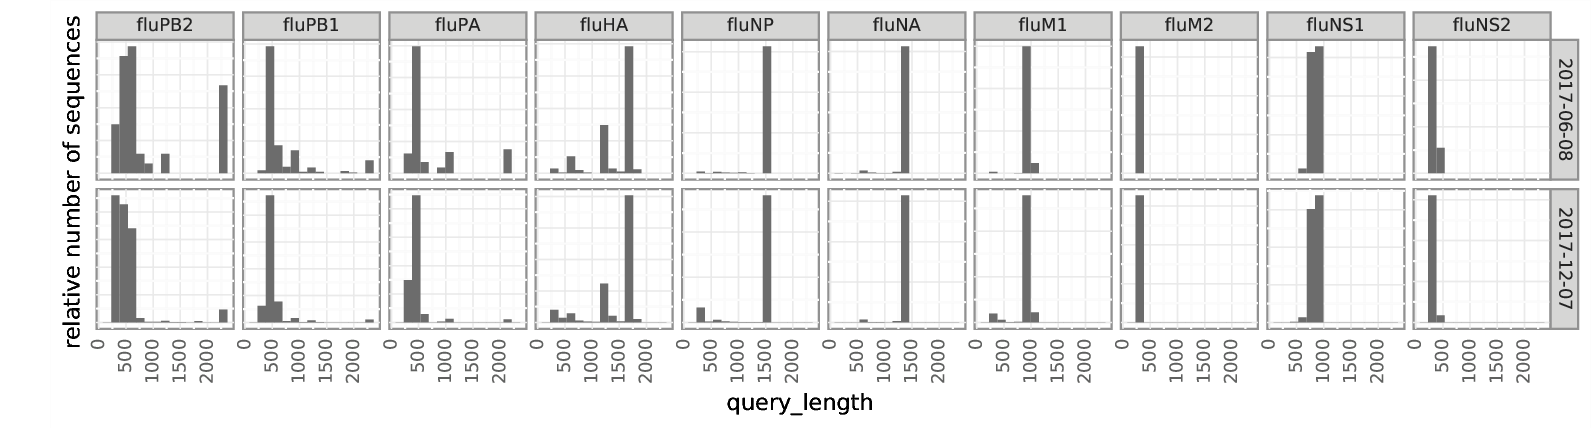

In [195]:
(ggplot(df_QC, aes('query_length')) +
    geom_histogram(aes(x='query_length', y='..density..'), bins=15) +
    facet_grid('samplename ~ gene_aligned_target', scales='free_y') +
    theme(axis_text_x=element_text(angle=90, hjust=0.5),
          axis_text_y=element_blank(), axis_ticks=element_blank()) +
    ylab("relative number of sequences")
    ).save('_temp.pdf', width=1.4 * len(targets), height=1.4 * len(seqruns))
showPDF('_temp.pdf')